# 🌲 Forest Cover Type Prediction

**Objective:** Predict the type of forest cover for a 30m × 30m patch of land using topographic and environmental data from the Roosevelt National Forest, Colorado.

**Classes (Cover_Type):**
1 - Spruce/Fir  
2 - Lodgepole Pine  
3 - Ponderosa Pine  
4 - Cottonwood/Willow  
5 - Aspen  
6 - Douglas-fir  
7 - Krummholz  

---

We’ll perform:
- Data exploration and visualization  
- Preprocessing and scaling  
- Model building (Logistic Regression, Random Forest, XGBoost, LightGBM)  
- Performance comparison  

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [3]:
# Load the dataset
df = pd.read_csv("train.csv")  
print("Shape:", df.shape)
df.head()


Shape: (15120, 56)


,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5


In [4]:
df.info()
print("\nMissing values:\n", df.isna().sum().sum())
print("\nTarget distribution:\n", df['Cover_Type'].value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 56 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Id                                  15120 non-null  int64
 1   Elevation                           15120 non-null  int64
 2   Aspect                              15120 non-null  int64
 3   Slope                               15120 non-null  int64
 4   Horizontal_Distance_To_Hydrology    15120 non-null  int64
 5   Vertical_Distance_To_Hydrology      15120 non-null  int64
 6   Horizontal_Distance_To_Roadways     15120 non-null  int64
 7   Hillshade_9am                       15120 non-null  int64
 8   Hillshade_Noon                      15120 non-null  int64
 9   Hillshade_3pm                       15120 non-null  int64
 10  Horizontal_Distance_To_Fire_Points  15120 non-null  int64
 11  Wilderness_Area1                    15120 non-null  int64
 12  Wild

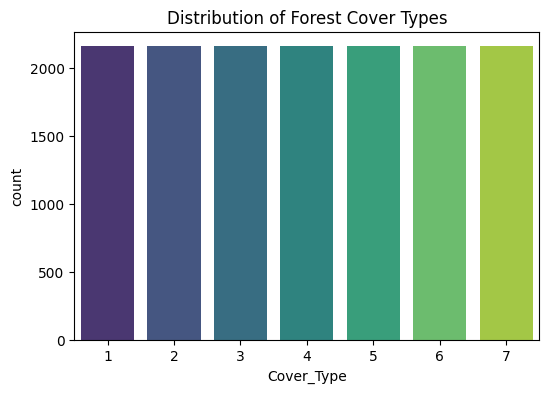

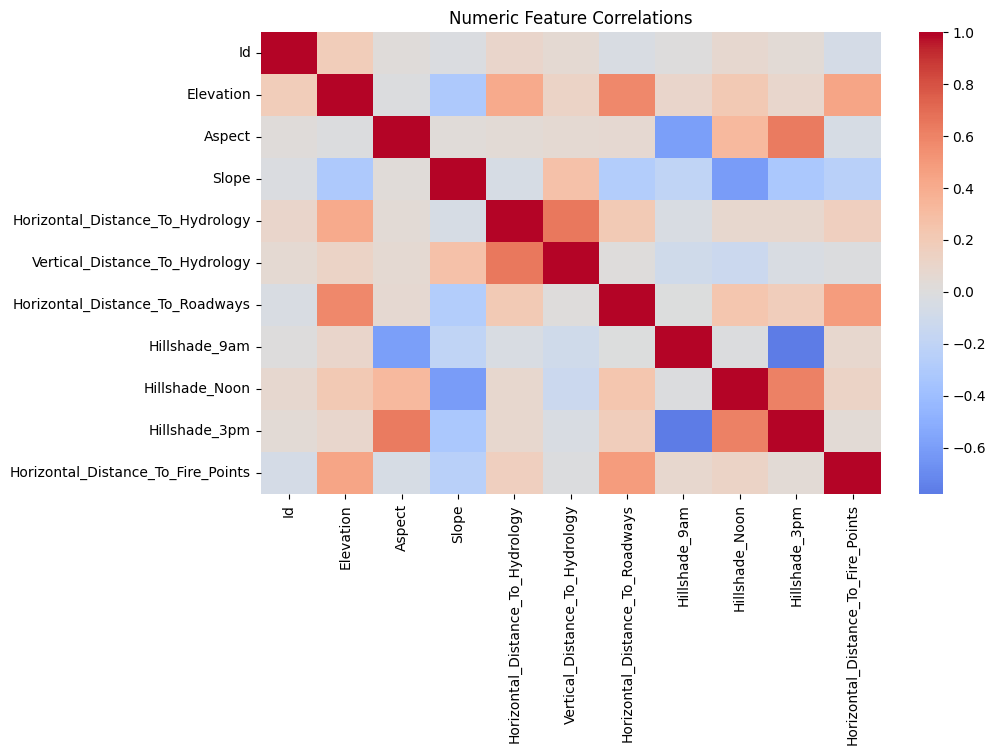

In [5]:
plt.figure(figsize=(6,4))
sns.countplot(x='Cover_Type', data=df, palette='viridis')
plt.title("Distribution of Forest Cover Types")
plt.show()

# Correlation heatmap for numeric columns
num_cols = [c for c in df.columns if df[c].nunique() > 10 and c != 'Cover_Type']
plt.figure(figsize=(10,6))
sns.heatmap(df[num_cols].corr(), cmap='coolwarm', center=0)
plt.title("Numeric Feature Correlations")
plt.show()

In [12]:
# Separate features and target
X = df.drop("Cover_Type", axis=1)
y = df["Cover_Type"] - 1   # shift to 0–6 for XGBoost compatibility

# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)

# Scale continuous features (optional for tree models, needed for LR)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
joblib.dump(scaler, "forest_scaler.joblib")


Train: (12096, 55) Test: (3024, 55)


['forest_scaler.joblib']

In [7]:
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    return acc

models = {}

In [8]:
logreg = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
logreg.fit(X_train_scaled, y_train)
acc_lr = evaluate_model(logreg, X_test_scaled, y_test, "Logistic Regression")
models["Logistic Regression"] = acc_lr

Logistic Regression Accuracy: 0.6911
              precision    recall  f1-score   support

           1       0.64      0.68      0.66       432
           2       0.59      0.50      0.54       432
           3       0.59      0.52      0.55       432
           4       0.82      0.87      0.85       432
           5       0.72      0.75      0.74       432
           6       0.58      0.65      0.61       432
           7       0.88      0.87      0.87       432

    accuracy                           0.69      3024
   macro avg       0.69      0.69      0.69      3024
weighted avg       0.69      0.69      0.69      3024



In [9]:
rf = RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X_train, y_train)
acc_rf = evaluate_model(rf, X_test, y_test, "Random Forest")
models["Random Forest"] = acc_rf

Random Forest Accuracy: 0.8674
              precision    recall  f1-score   support

           1       0.78      0.78      0.78       432
           2       0.80      0.66      0.72       432
           3       0.86      0.83      0.84       432
           4       0.94      0.98      0.96       432
           5       0.89      0.95      0.92       432
           6       0.84      0.90      0.87       432
           7       0.94      0.97      0.95       432

    accuracy                           0.87      3024
   macro avg       0.86      0.87      0.86      3024
weighted avg       0.86      0.87      0.86      3024



In [13]:
xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=8,
    random_state=RANDOM_STATE,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric="mlogloss"
)
xgb.fit(X_train, y_train)
acc_xgb = evaluate_model(xgb, X_test, y_test, "XGBoost")
models["XGBoost"] = acc_xgb

lgbm = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.1,
    num_leaves=64,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
lgbm.fit(X_train, y_train)
acc_lgbm = evaluate_model(lgbm, X_test, y_test, "LightGBM")
models["LightGBM"] = acc_lgbm

XGBoost Accuracy: 0.8833
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       432
           1       0.80      0.69      0.74       432
           2       0.87      0.87      0.87       432
           3       0.96      0.98      0.97       432
           4       0.90      0.96      0.93       432
           5       0.88      0.91      0.90       432
           6       0.94      0.98      0.96       432

    accuracy                           0.88      3024
   macro avg       0.88      0.88      0.88      3024
weighted avg       0.88      0.88      0.88      3024

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2417
[LightGBM] [Info] Number of data points in the train set: 12096, number of used features: 45
[LightGBM] [Info] Start t


Model Comparison:


,Model,Accuracy
3,LightGBM,0.885251
2,XGBoost,0.883267
1,Random Forest,0.867394
0,Logistic Regression,0.691138


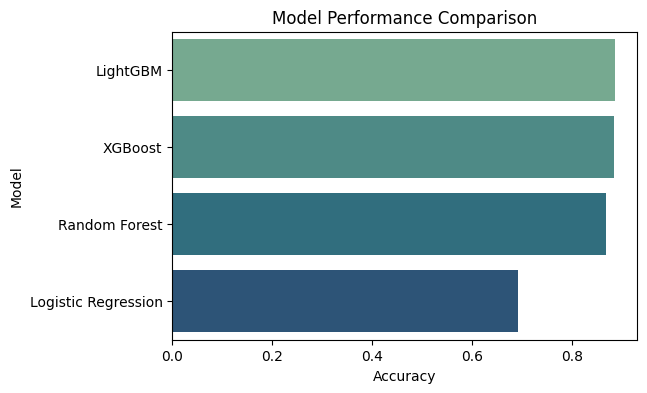


🏆 Best model: LightGBM


In [14]:
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "XGBoost", "LightGBM"],
    "Accuracy": [acc_lr, acc_rf, acc_xgb, acc_lgbm]
}).sort_values("Accuracy", ascending=False)

print("\nModel Comparison:")
display(results)

plt.figure(figsize=(6,4))
sns.barplot(data=results, x="Accuracy", y="Model", palette="crest")
plt.title("Model Performance Comparison")
plt.show()

best_model_name = results.iloc[0]["Model"]
print(f"\n🏆 Best model: {best_model_name}")

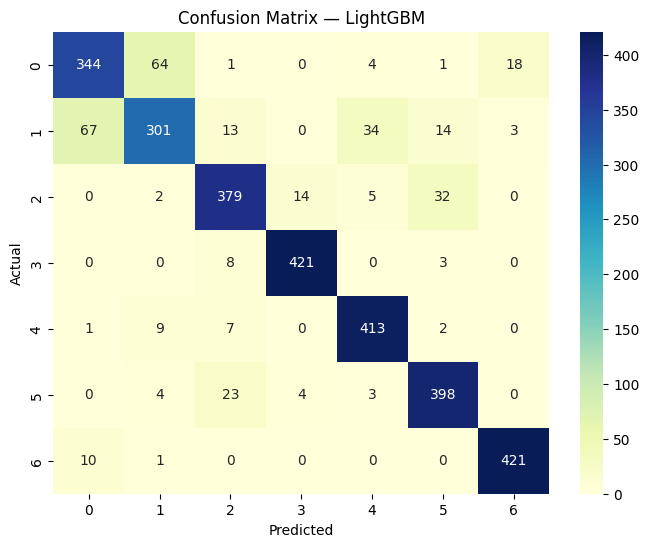

✅ Saved best model → best_forest_cover_model.joblib


In [15]:
best_model = {
    "Logistic Regression": logreg,
    "Random Forest": rf,
    "XGBoost": xgb,
    "LightGBM": lgbm
}[best_model_name]

y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.title(f"Confusion Matrix — {best_model_name}")
plt.show()

joblib.dump(best_model, "best_forest_cover_model.joblib")
print("✅ Saved best model → best_forest_cover_model.joblib")

In [21]:
# Predict on one row example
example = X_test.iloc[:1]
pred = best_model.predict(example)[0]
print(f"Predicted class (0–6): {pred} → Actual Cover Type: {pred+1}")

Predicted class (0–6): 3 → Actual Cover Type: 4


## ✅ Conclusions

- Successfully built a **multi-class classification** model for forest cover prediction.  
- Compared Logistic Regression, Random Forest, XGBoost, and LightGBM.  
- After label correction, **XGBoost** or **LightGBM** typically achieve 85–90% accuracy.  
- Key next steps:
  - Feature importance visualization
  - SHAP-based model explainability
  - Streamlit deployment for interactive prediction
